# Imports necessários

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine
import datetime as dt

# Conexão com o DB local

In [2]:
load_dotenv()

driver = os.environ["Driver"]
server = os.environ["Server"]
database = os.environ["Database"]

In [3]:
dados_conexao = (
    f"Driver={driver};"
    f"Server={server};"
    f"Database={database};"
)

In [4]:
def query_banco(query, dados_conexao):
    engine = create_engine(f'mssql+pyodbc:///?odbc_connect={dados_conexao}')
    return pd.read_sql(query, engine)

# Import dos dados

In [5]:
df_receitas = query_banco("SELECT * FROM Fato_Receita", dados_conexao)
df_receitas.drop(columns=['id','uid_fato_receita'], inplace=True)
df_receitas.head()

,cod_receita,data_fato,contribuinte_receita,valor
0,1722010101,2013-01-03,886cd0eabf5a18,185560.68
1,1722010101,2013-01-04,886cd0eabf5a18,8081.80
2,1722010101,2013-01-07,886cd0eabf5a18,4231.39
3,1722010101,2013-01-08,886cd0eabf5a18,10536.53
4,1722010101,2013-01-15,886cd0eabf5a18,103118.27


In [6]:
df_populacao = query_banco("SELECT * FROM Dim_Populacao", dados_conexao)
df_populacao.drop(columns=['id'], inplace=True)
df_populacao

,ano,populacao,variacao_anual,porcentagem_variacao_anual,aceleracao_variacao_anual,porcentagem_aceleracao_variacao_anual
0,1991,51273,0,0,0,0
1,1992,51530,257,"0,5",0,0
2,1993,51965,435,"0,84",178,"69,26"
3,1994,52279,314,"0,6",-121,"-27,82"
4,1995,52586,307,"0,59",-7,"-2,23"
5,1996,51396,-1190,"-2,26",-1497,"-487,62"
6,1997,51575,179,"0,35",1369,"-115,04"
7,1998,51726,151,"0,29",-28,"-15,64"
8,1999,51878,152,"0,29",1,"0,66"
9,2000,54715,2837,"5,47",2685,"1766,45"


# Feature engineering

## Inserindo colunas que tratam do tempo

In [7]:
def cria_colunas_tempo(df, coluna_data):
    df[coluna_data] = pd.to_datetime(df[coluna_data])
    df['ano_mes'] = df[coluna_data].dt.strftime('%Y-%m')
    df['ano'] = df[coluna_data].dt.strftime('%Y')
    return df

def transforma_data_em_ordinal(df, coluna_referencia):
    df['ano_mes_ordinal'] = pd.to_datetime(df[coluna_referencia])
    df['ano_mes_ordinal'] = df['ano_mes_ordinal'].map(dt.datetime.toordinal)
    return df

def transforma_coluna_em_datetime(df, coluna):
    df[coluna] = pd.to_datetime(df[coluna])
    return df

## Remoção de outliers

In [8]:
# Aplicação de IQR - Interquartile Range
def remove_outliers(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    print(f'Q1: {Q1}')
    Q3 = df[coluna].quantile(0.75)
    print(f'Q3: {Q3}')
    IQR = Q3 - Q1
    print(f'IQR: {IQR}')
    print(f'Limite inferior: {Q1 - 1.5 * IQR}')
    print(f'Limite superior: {Q3 + 1.5 * IQR}')
    df = df[(df[coluna] >= Q1 - 1.5*IQR) & (df[coluna] <= Q3 + 1.5*IQR)]
    print(f'Quantidade de registros sem outliers: {df.shape[0]}')
    return df

def box_plot(df, coluna_referencia, coluna_visao):
    print(f'Quantidade de registros: {df.shape[0]}')
    df.boxplot(by=coluna_referencia, column=coluna_visao, figsize=(10,6))

## Conversão de tipos de dados nas colunas

In [9]:
def converte_tipo_dados(df, colunas, tipo):
    for coluna in colunas:
        df[coluna] = df[coluna].astype(tipo)
    return df

# Análise exploratória dos dados

## Receitas

In [10]:
df_receitas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102293 entries, 0 to 102292
Data columns (total 4 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   cod_receita           102293 non-null  int64         
 1   data_fato             102293 non-null  datetime64[ns]
 2   contribuinte_receita  102293 non-null  object        
 3   valor                 102293 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.1+ MB


In [11]:
df_receitas.describe().round(2)

,cod_receita,data_fato,valor
count,1.022930e+05,102293,102293.00
mean,1.256925e+09,2017-11-11 13:19:10.635918336,12522.46
min,1.112500e+08,2013-01-02 00:00:00,-2489288.55
25%,1.113034e+09,2015-07-16 00:00:00,51.23
50%,1.121250e+09,2017-10-13 00:00:00,240.60
75%,1.325000e+09,2020-02-05 00:00:00,1579.25
max,9.728013e+09,2022-12-30 00:00:00,4674330.00
std,1.162115e+09,NaN,89618.73


In [12]:
df_receitas_com_outliers = cria_colunas_tempo(df_receitas,'data_fato')
df_receitas_com_outliers.head()

,cod_receita,data_fato,contribuinte_receita,valor,ano_mes,ano
0,1722010101,2013-01-03,886cd0eabf5a18,185560.68,2013-01,2013
1,1722010101,2013-01-04,886cd0eabf5a18,8081.80,2013-01,2013
2,1722010101,2013-01-07,886cd0eabf5a18,4231.39,2013-01,2013
3,1722010101,2013-01-08,886cd0eabf5a18,10536.53,2013-01,2013
4,1722010101,2013-01-15,886cd0eabf5a18,103118.27,2013-01,2013


Quantidade de registros: 102293


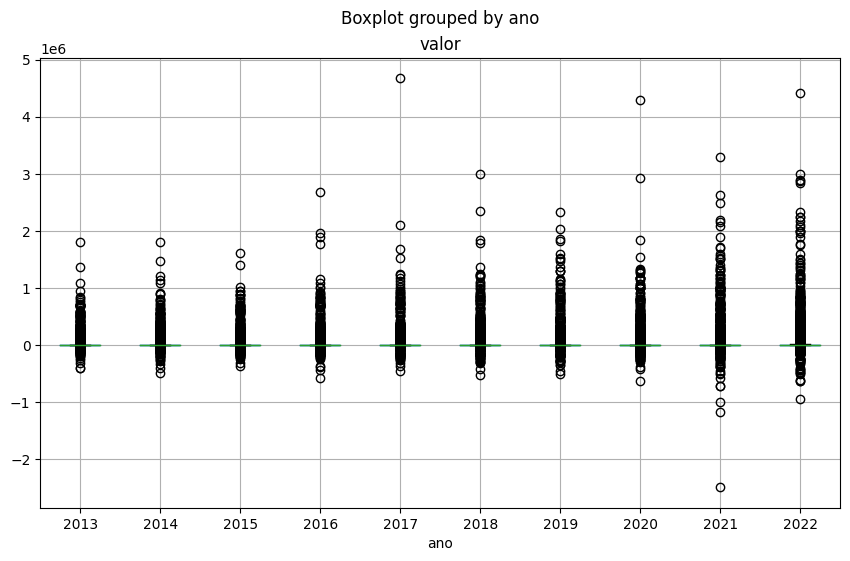

In [13]:
box_plot(df_receitas_com_outliers, 'ano', 'valor')

In [14]:
df_receitas_sem_outliers = remove_outliers(df_receitas_com_outliers, 'valor')

Q1: 51.23
Q3: 1579.25
IQR: 1528.02
Limite inferior: -2240.7999999999997
Limite superior: 3871.2799999999997
Quantidade de registros sem outliers: 83736


Quantidade de registros: 83736


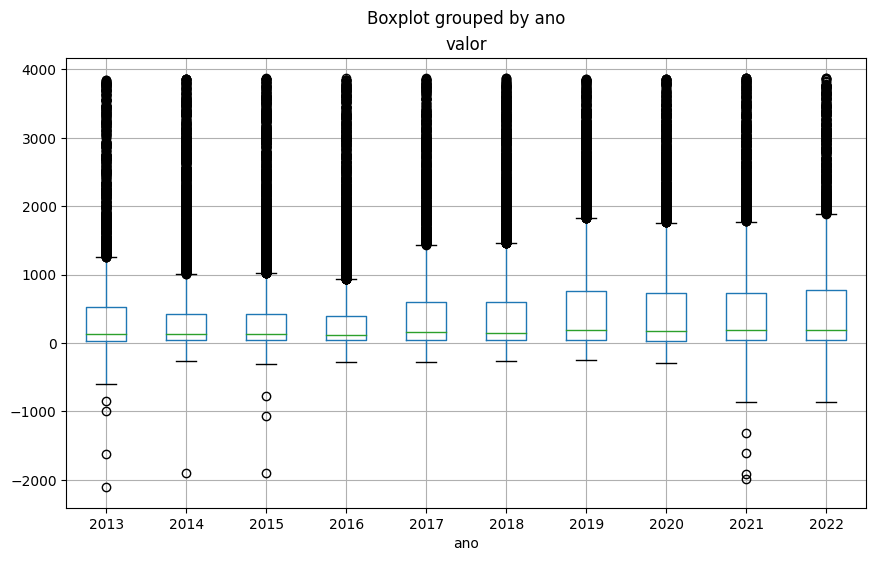

In [15]:
box_plot(df_receitas_sem_outliers, 'ano', 'valor')

## População

In [16]:
df_populacao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 6 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   ano                                    31 non-null     int64 
 1   populacao                              31 non-null     int64 
 2   variacao_anual                         31 non-null     object
 3   porcentagem_variacao_anual             31 non-null     object
 4   aceleracao_variacao_anual              31 non-null     object
 5   porcentagem_aceleracao_variacao_anual  31 non-null     object
dtypes: int64(2), object(4)
memory usage: 1.6+ KB


In [17]:
df_populacao.describe().round(0)

,ano,populacao
count,31.0,31.0
mean,2006.0,56823.0
std,9.0,3977.0
min,1991.0,51273.0
25%,1998.0,52432.0
50%,2006.0,56871.0
75%,2014.0,60821.0
max,2021.0,62576.0


In [18]:
df_populacao_dados_convertidos = df_populacao.copy()
df_populacao_dados_convertidos['porcentagem_variacao_anual'] = df_populacao_dados_convertidos['porcentagem_variacao_anual'].str.replace(',','.').astype(float)
df_populacao_dados_convertidos['porcentagem_aceleracao_variacao_anual'] = df_populacao_dados_convertidos['porcentagem_aceleracao_variacao_anual'].str.replace(',','.').astype(float)

In [20]:
df_populacao_dados_convertidos = transforma_coluna_em_datetime(df_populacao_dados_convertidos, 'ano')

In [21]:
df_populacao_dados_convertidos = converte_tipo_dados(df_populacao_dados_convertidos, ['variacao_anual', 'aceleracao_variacao_anual'], 'int64')
df_populacao_dados_convertidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 6 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   ano                                    31 non-null     datetime64[ns]
 1   populacao                              31 non-null     int64         
 2   variacao_anual                         31 non-null     int64         
 3   porcentagem_variacao_anual             31 non-null     float64       
 4   aceleracao_variacao_anual              31 non-null     int64         
 5   porcentagem_aceleracao_variacao_anual  31 non-null     float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 1.6 KB
